# CS 109A/STAT 121A/AC 209A/CSCI E-109A: Homework 7
# LDA/QDA and Decision Trees

**Harvard University**<br/>
**Fall 2017**<br/>
**Instructors**: Pavlos Protopapas, Kevin Rader, Rahul Dave, Margo Levine

---

### INSTRUCTIONS

- To submit your assignment follow the instructions given in canvas.
- Restart the kernel and run the whole notebook again before you submit. 
- Do not include your name(s) in the notebook if you are submitting as a group. 
- If you submit individually and you have worked with someone, please include the name of your [one] partner below. 

---

Your partner's name (if you submit separately):

Enrollment Status (109A, 121A, 209A, or E109A):

Import libraries:

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegressionCV
import sklearn.metrics as metrics
from sklearn.preprocessing import PolynomialFeatures
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
#import pydotplus
#import io
from sklearn.tree import export_graphviz
from IPython.display import Image
from IPython.display import display
%matplotlib inline

import statsmodels.api as sm
from sklearn.model_selection import KFold
from sklearn.model_selection import LeaveOneOut

/Users/yijunshen/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools



## Multiclass Thyroid Classification

In this problem, you will build a model for diagnosing disorders in a patient's thyroid gland. Given the results of medical tests on a patient, the task is to classify the patient either as:
- *normal* (class 1)
- having *hyperthyroidism* (class 2)
- or having *hypothyroidism* (class 3). 

The data set is provided in the file `hw7_dataset.csv`. Columns 1-2 contain biomarkers for a patient (predictors):
- Biomarker 1: (Logarithm of) level of basal thyroid-stimulating hormone (TSH) as measured by radioimmuno assay
- Biomarker 2: (Logarithm of) maximal absolute difference of TSH value after injection of 200 micro grams of thyrotropin-releasing hormone as compared to the basal value.

The last column contains the diagnosis for the patient from a medical expert. This data set was obtained from the UCI machine learning repository.

Notice that unlike previous exercises, the task at hand is a 3-class classification problem. We will explore the use of different methods for multiclass classification.

First task: split the data using the following code:

In [2]:
np.random.seed(9001)
df = pd.read_csv('hw7_dataset.csv')
df = df.rename(columns={'Biomarker 1': 'Biomarker_1', 'Biomarker 2': 'Biomarker_2'})
msk = np.random.rand(len(df)) < 0.5
data_train = df[msk]
data_test = df[~msk]

In [3]:
print(data_train.shape, data_test.shape)
data_train.head()

(102, 3) (113, 3)


,Biomarker_1,Biomarker_2,Diagnosis
0,0.262372,0.875473,1.0
5,0.336479,1.098616,1.0
9,0.182330,-1.609488,2.0
12,-0.223131,0.788462,1.0
13,0.587792,1.458617,1.0


In [4]:
data_train.describe()

,Biomarker_1,Biomarker_2,Diagnosis
count,102.000000,102.000000,102.000000
mean,0.344213,0.136095,1.392157
std,0.830087,2.201512,0.677164
min,-2.302485,-11.512925,1.000000
25%,-0.105349,-1.076236,1.000000
50%,0.222351,0.641859,1.000000
75%,0.470010,1.273894,2.000000
max,4.032469,3.970292,3.000000


## Question 1: Fit Classification Models

1. Generate a 2D scatter plot of the training set, denoting each class with a different color. Does it appear that the data points can be separated well by a linear classifier?

2. Briefly explain the difference between multinomial logistic regression and one-vs-rest (OvR) logistic regression methods for fitting a multiclass classifier (in 2-3 sentences).

3. Fit linear classification models on the thyroid data set using both the methods.  You should use $L_2$ regularization in both cases, tuning the regularization parameter using cross-validation.  Is there a difference in the overall classification accuracy of the two methods on the training and test sets?

4. Also, compare the training and test accuracies of these models with the following classification methods:
    - Multiclass Logistic Regression with quadratic terms 
    - Linear Discriminant Analysis
    - Quadratic Discriminant Analysis
    - k-Nearest Neighbors
    <br>
*Note:* you may use either the OvR or multinomial variant for the multiclass logistic regression (with $L_2$ regularization). Do not forget to use cross-validation to choose the regularization parameter, and also the number of neighbors in k-NN. 

5. Does the inclusion of the polynomial terms in logistic regression yield better test accuracy compared to the model with only linear terms? 


*Hint:* You may use the `KNeighborsClassifier` class to fit a k-NN classification model.

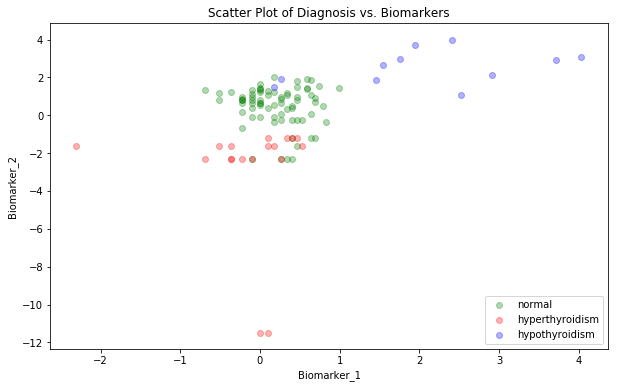

In [5]:
data_train_1 = data_train.loc[data_train['Diagnosis'] == 1.0]
data_train_2 = data_train.loc[data_train['Diagnosis'] == 2.0]
data_train_3 = data_train.loc[data_train['Diagnosis'] == 3.0]

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.scatter(data_train_1.Biomarker_1, data_train_1.Biomarker_2, label="normal", color="green", alpha=0.3)
ax.scatter(data_train_2.Biomarker_1, data_train_2.Biomarker_2, label="hyperthyroidism", color="red", alpha=0.3)
ax.scatter(data_train_3.Biomarker_1, data_train_3.Biomarker_2, label="hypothyroidism", color="blue", alpha=0.3)
ax.set_xlabel("Biomarker_1")
ax.set_ylabel("Biomarker_2")
ax.set_title("Scatter Plot of Diagnosis vs. Biomarkers")
ax.legend(loc=4)
plt.show()

## Answer:
### 1. Generate a 2D scatter plot of the training set, denoting each class with a different color. Does it appear that the data points can be separated well by a linear classifier?
- Possibly yes. We can draw a nealy horizontal line to divide green and red dots, though this may cause some green dots classified into red ones. We can also draw a line to divide blue and green dots, with only a few blue dots misclassified into green.
- Generally speaking, the data points can be separated well by a linear clasifier.

### 2. Briefly explain the difference between multinomial logistic regression and one-vs-rest (OvR) logistic regression methods for fitting a multiclass classifier (in 2-3 sentences).
- In multinomial logistic regression, dependent variable is nominal with more than two levels, such as "normal", "hyperthyroidism" and "hypothyroidism" in the above example. 
- One-vs-rest (OvR) compares one group to everything else, for example, normal and abnormal, where abnormal is hyperthyroidism and hypothyroidism. But there could be difference between hyperthyroidism and hypothyroidism, which can be analyzed using multinomial logistic regression.

In [6]:
X_train = data_train[["Biomarker_1", "Biomarker_2"]]
y_train = data_train["Diagnosis"]
X_test = data_test[["Biomarker_1", "Biomarker_2"]]
y_test = data_test["Diagnosis"]

#### Multinomial Logistic Regression

In [7]:
# Multinomial Logistic Regression
X_train_mul = sm.add_constant(X_train)
X_test_mul = sm.add_constant(X_test)
reg_Cs = np.hstack((10.**np.arange(-5, 0), 10**np.arange(0, 6)))
log_multi = LogisticRegressionCV(reg_Cs, cv=5, penalty='l2', multi_class="multinomial")
log_multi.fit(X_train_mul, y_train)
print("Multinomial Logistic regression classifier on train set has accuracy:", log_multi.score(X_train_mul, y_train))
print("Multinomial Logistic regression classifier on test set has accuracy:", log_multi.score(X_test_mul, y_test))

Multinomial Logistic regression classifier on train set has accuracy: 0.892156862745
Multinomial Logistic regression classifier on test set has accuracy: 0.884955752212


#### One-vs-rest (OvR) Logistic Regression

In [8]:
# One-vs-rest (OvR) Logistic Regression
log_ovr = LogisticRegressionCV(reg_Cs, cv=5, penalty='l2', multi_class="ovr")
log_ovr.fit(X_train_mul, y_train)
print("OVR Logistic regression classifier on train set has accuracy:", log_ovr.score(X_train_mul, y_train))
print("OVR Logistic regression classifier on test set has accuracy:", log_ovr.score(X_test_mul, y_test))

OVR Logistic regression classifier on train set has accuracy: 0.843137254902
OVR Logistic regression classifier on test set has accuracy: 0.840707964602


### 3. Fit linear classification models on the thyroid data set using both the methods. You should use  $L_2$ regularization in both cases, tuning the regularization parameter using cross-validation. Is there a difference in the overall classification accuracy of the two methods on the training and test sets?
- One obvious rsult is that accuracy score on train set is always higher than accuracy score on test set.
- Overall classification accuracy of the multinomial method is higher than the one of the OvR method. I think this is because for the current dataset, the three classes are exclusive, and therefore multinomial logistic regression is a better choice.

#### Multiclass Logistic Regression with quadratic terms

In [9]:
# Multiclass Logistic Regression with quadratic terms
X_train2 = X_train.copy()
X_test2 = X_test.copy()
X_train2["B1_sq"] = X_train2["Biomarker_1"]**2
X_train2["B2_sq"] = X_train2["Biomarker_2"]**2
X_test2["B1_sq"] = X_test2["Biomarker_1"]**2
X_test2["B2_sq"] = X_test2["Biomarker_2"]**2

X_train_mul2 = sm.add_constant(X_train2)
X_test_mul2 = sm.add_constant(X_test2)
log_multi2 = LogisticRegressionCV(reg_Cs, cv=5, penalty='l2', multi_class="multinomial")
log_multi2.fit(X_train_mul2, y_train)
print("Multinomial Logistic regression with queadratic terms on train set has accuracy:",\
      log_multi2.score(X_train_mul2, y_train))
print("Multinomial Logistic regression with queadratic terms on test set has accuracy:",\
      log_multi2.score(X_test_mul2, y_test))

Multinomial Logistic regression with queadratic terms on train set has accuracy: 0.892156862745
Multinomial Logistic regression with queadratic terms on test set has accuracy: 0.884955752212


#### Linear Discriminant Analysis

In [10]:
# Linear Discriminant Analysis
# cross validation
LDA = LinearDiscriminantAnalysis()
model_LDA = LDA.fit(X_train, y_train)
print("LDA on train set has accuracy:", model_LDA.score(X_train, y_train))
print("LDA on test set has accuracy:", model_LDA.score(X_test, y_test))

LDA on train set has accuracy: 0.872549019608
LDA on test set has accuracy: 0.83185840708


In [11]:
lda = LinearDiscriminantAnalysis()

train_scores = []
valid_scores = []

for itrain, ivalid in KFold(n_splits=5, shuffle=True, random_state=9001).split(X_train.index):
    X_train_cv = X_train.iloc[itrain,:]
    y_train_cv = y_train.iloc[itrain]
    X_valid_cv = X_train.iloc[ivalid,:]
    y_valid_cv = y_train.iloc[ivalid]
    
    lda.fit(X_train_cv, y_train_cv)
    train_scores.append(lda.score(X_train_cv, y_train_cv))
    valid_scores.append(lda.score(X_valid_cv, y_valid_cv))

train_scores_mean = np.mean(train_scores)
valid_scores_mean = np.mean(valid_scores)
print(train_scores)
print(valid_scores)
print(train_scores_mean, valid_scores_mean)

[0.86419753086419748, 0.86419753086419748, 0.87804878048780488, 0.86585365853658536, 0.87804878048780488]
[0.8571428571428571, 0.90476190476190477, 0.84999999999999998, 0.90000000000000002, 0.94999999999999996]
0.870069256248 0.892380952381


/Users/yijunshen/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


#### Quadratic Discriminant Analysis

In [12]:
# Quadratic Discriminant Analysis
# cross validation
QDA = QuadraticDiscriminantAnalysis()
model_QDA = QDA.fit(X_train, y_train)
print("QDA on train set has accuracy:", model_QDA.score(X_train, y_train))
print("QDA on test set has accuracy:", model_QDA.score(X_train, y_train))

QDA on train set has accuracy: 0.872549019608
QDA on test set has accuracy: 0.872549019608


#### k-Nearest Neighbors

In [13]:
# k-Nearest Neighbors
train_scores = []
valid_scores = []

for itrain, ivalid in KFold(n_splits=5, shuffle=True, random_state=9001).split(X_train.index):
    X_train_cv = X_train.iloc[itrain,:]
    y_train_cv = y_train.iloc[itrain]
    X_valid_cv = X_train.iloc[ivalid,:]
    y_valid_cv = y_train.iloc[ivalid]
    train_score = []
    valid_score = []
    
    for i in range(1,50):
        knn_i = KNeighborsClassifier(i)
        knn_i.fit(X_train_cv, y_train_cv)
        train_score.append(knn_i.score(X_train_cv, y_train_cv))
        valid_score.append(knn_i.score(X_valid_cv, y_valid_cv))
    train_scores.append(train_score)
    valid_scores.append(valid_score)

train_scores = np.array(train_scores)
print("train score with k from 1 to 50:")
print(np.mean(train_scores, axis=0))
valid_scores = np.array(valid_scores)
print("valid score with k from 1 to 50:")
print(np.mean(valid_scores, axis=0))
best_k = np.argmax(np.mean(valid_scores, axis=0)) + 1
print("best choice of k is:", best_k)

train score with k from 1 to 50:
[ 0.97548931  0.9092442   0.92890696  0.9166215   0.92152966  0.88467329
  0.88958145  0.87976513  0.88964167  0.88476363  0.87979524  0.87735622
  0.88229449  0.85284553  0.85284553  0.82351701  0.83574225  0.81613972
  0.82107799  0.79891599  0.79891599  0.79400783  0.79153869  0.79397772
  0.79644685  0.74504667  0.74504667  0.73041253  0.73041253  0.72059621
  0.72059621  0.71571816  0.71571816  0.71571816  0.71571816  0.71571816
  0.71571816  0.71571816  0.71571816  0.71571816  0.71571816  0.71571816
  0.71571816  0.71571816  0.71571816  0.71571816  0.71571816  0.71571816
  0.71571816]
valid score with k from 1 to 50:
[ 0.86238095  0.84238095  0.91095238  0.87190476  0.86142857  0.81238095
  0.84142857  0.83190476  0.88095238  0.80333333  0.83238095  0.81333333
  0.82333333  0.80333333  0.82285714  0.80285714  0.81285714  0.80285714
  0.81285714  0.78380952  0.78380952  0.7647619   0.7647619   0.72571429
  0.72571429  0.71619048  0.71619048  0.7161

In [14]:
knn3 = KNeighborsClassifier(3)
knn3.fit(X_train, y_train)
print("knn with k=3 on train set has accuracy:", knn3.score(X_train, y_train))
print("knn with k=3 on test set has accuracy:", knn3.score(X_test, y_test))

knn with k=3 on train set has accuracy: 0.93137254902
knn with k=3 on test set has accuracy: 0.867256637168


## Answer:
### 4. Compare the training and test accuracies of these models with these classification methods:
- 

## Answer:
### 5. Does the inclusion of the polynomial terms in logistic regression yield better test accuracy compared to the model with only linear terms?
- Not really. With the inclusin of the polynomial terms in logistic regression, the accuracy scores of both train and test are still the same as the model with only linear terms.

## Question 2: Visualize Decision Boundaries

The following code will allow you to visualize the decision boundaries of a given classification model.

In [17]:
#--------  plot_decision_boundary
# A function that visualizes the data and the decision boundaries
# Input: 
#      x (predictors)
#      y (labels)
#      model (the classifier you want to visualize)
#      title (title for plot)
#      ax (a set of axes to plot on)
#      poly_degree (highest degree of polynomial terms included in the model; None by default)

def plot_decision_boundary(x, y, model, title, ax, poly_degree=None):
    # Create mesh
    # Interval of points for biomarker 1
    min0 = x[:,0].min()
    max0 = x[:,0].max()
    interval0 = np.arange(min0, max0, (max0-min0)/100)
    n0 = np.size(interval0)
    
    # Interval of points for biomarker 2
    min1 = x[:,1].min()
    max1 = x[:,1].max()
    interval1 = np.arange(min1, max1, (max1-min1)/100)
    n1 = np.size(interval1)

    # Create mesh grid of points
    x1, x2 = np.meshgrid(interval0, interval1)
    x1 = x1.reshape(-1,1)
    x2 = x2.reshape(-1,1)
    xx = np.concatenate((x1, x2), axis=1)

    # Predict on mesh of points
    # Check if polynomial terms need to be included
    if(poly_degree!=None):
        # Use PolynomialFeatures to generate polynomial terms
        poly = PolynomialFeatures(poly_degree)
        xx_ = poly.fit_transform(xx)
        yy = model.predict(xx_) 
    else:   
        yy = model.predict(xx)
        
    yy = yy.reshape((n0, n1))

    # Plot decision surface
    x1 = x1.reshape(n0, n1)
    x2 = x2.reshape(n0, n1)
    ax.contourf(x1, x2, yy, cmap=plt.cm.coolwarm, alpha=0.8)
    
    # Plot scatter plot of data
    yy = y.reshape(-1,)
    ax.scatter(x[yy==1,0], x[yy==1,1], c='blue', label='Normal', cmap=plt.cm.coolwarm)
    ax.scatter(x[yy==2,0], x[yy==2,1], c='cyan', label='Hyper', cmap=plt.cm.coolwarm)
    ax.scatter(x[yy==3,0], x[yy==3,1], c='red', label='Hypo', cmap=plt.cm.coolwarm)
    
    # Label axis, title
    ax.set_title(title)
    ax.set_xlabel('Biomarker 1')
    ax.set_ylabel('Biomarker 2')

**Note:** The provided code uses `sklearn`'s `PolynomialFeatures` to generate higher-order polynomial terms, with degree `poly_degree`. 
Also, if you have loaded the data sets into `pandas` data frames, you may use the `as_matrix` function to obtain a `numpy` array from the data frame objects.

1. Use the above code to visualize the decision boundaries for each of the model fitted in the previous part.
2. Comment on the difference in the decision boundaries (if any) for the OvR and multinomial logistic regression models. Is there a difference between the decision boundaries for the linear logistic regression models and LDA. What about the decision boundaries for the quadratic logistic regression and QDA? Give an explanation for your answer.

### Decision Boundaries for Multinomial Logistic Regression

### Decision Boundaries for One-vs-rest (OvR) Logistic Regression

### Decision Boundaries for Multiclass Logistic Regression with quadratic terms

### Decision Boundaries for LDA

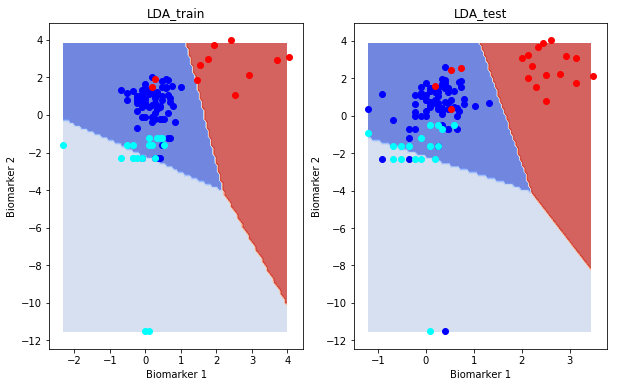

In [39]:
LDA = LinearDiscriminantAnalysis()
model_LDA = LDA.fit(X_train, y_train)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,6))
plot_decision_boundary(X_train.as_matrix(), y_train.as_matrix(), model_LDA, "LDA_train", ax1)
plot_decision_boundary(X_test.as_matrix(), y_test.as_matrix(), model_LDA, "LDA_test", ax2)

### Decision Boundaries for QDA


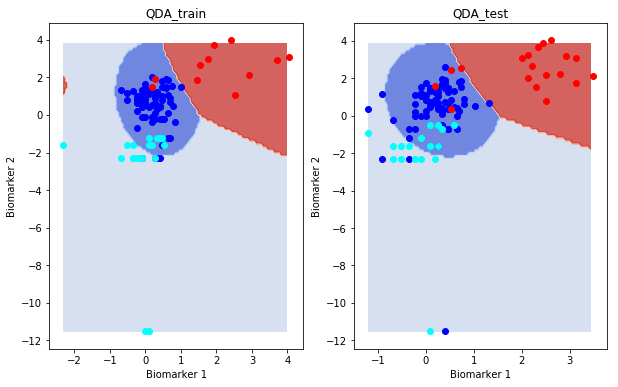

In [40]:
QDA = QuadraticDiscriminantAnalysis()
model_QDA = QDA.fit(X_train, y_train)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,6))
plot_decision_boundary(X_train.as_matrix(), y_train.as_matrix(), model_QDA, "QDA_train", ax1)
plot_decision_boundary(X_test.as_matrix(), y_test.as_matrix(), model_QDA, "QDA_test", ax2)

### Decision Boundaries for k-NN

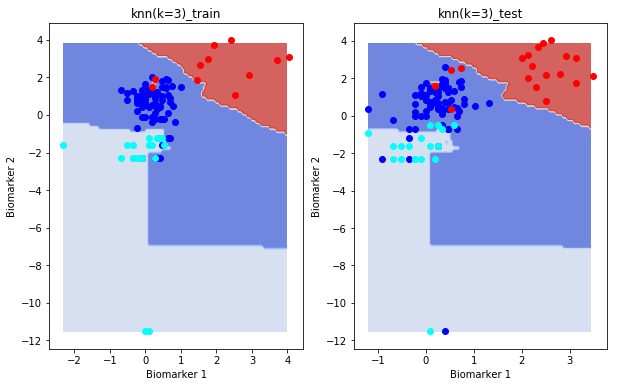

In [41]:
knn3 = KNeighborsClassifier(3)
knn3.fit(X_train, y_train)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,6))
plot_decision_boundary(X_train.as_matrix(), y_train.as_matrix(), knn3, "knn(k=3)_train", ax1)
plot_decision_boundary(X_test.as_matrix(), y_test.as_matrix(), knn3, "knn(k=3)_test", ax2)

## Question 3: Fit Decision Trees

We next try out decision trees for thyroid classification. For the following questions, you may use the *Gini* index as the splitting criterion while fitting the decision tree. 
1. Fit a decision tree model to the thyroid data set with (maximum) tree depths 2, 3, ..., 10. Make plots of the training and test accuracies as a function of the tree depth. Is there a depth at which the fitted decision tree model achieves near-perfect classification on the training set? If so, what can you say about the test accuracy of this model?

2. Use 5-fold cross-validation to find the optimal tree depth. How does the performance of a decision tree fitted with this depth compare with the models fitted in Part 2(a)?

3. Use the code provided in Part 2(c) to visualize the decision boundary of the fitted decision tree. How is the decision boundary of the decision tree model different from the other methods? Given an explanation for your observation.

4. Use the `export_graphviz` function in `sklearn` to generate a visualization of the tree diagram for the fitted model. Based on the visualization, explain *in words* how the fitted model diagnoses 'hypothyroidism' for a patient.  


*Note:* Look at the `export_graphviz` function in the `sklearn.tree` module. 

You can get a graphic for this visualization by pasting the generated graphviz file in the text box at http://www.webgraphviz.com/ , or you can do it on your own computer.

If you choose the do the latter, you will have to install `GraphViz` and `pydot` to use the decision tree rendering code. For this, you may execute the following commands in a terminal:

`$pip install graphviz`<br>
`$pip install pydot`

*Hint:* You may use the `DecisionTreeClassifier` class to fit a decision tree classifier and the `max_depth` attribute to set the tree depth. You may use the `cross_val_score` function for cross-validation with decision trees.

## Question 4: Too many models to choose from!

We have so far seen six different ways of fitting a classification model for thyroid classification problem: **linear logistic regression**, **logistic regression with polynomial terms**, **LDA**, **QDA**, **k-NN** and **decision tree**. Which of these methods should one use in practice? To answer this question, we now look at the pros and cons of each method.

1. Compare and contrast the six models based on each of the following criteria (a supporting table to summarize your  thoughts can be helpful):
  - Classification performance
  - Complexity of decision boundary
  - Memory storage
  - Ease of interpretability

2. If you were a clinician who had to use the classifier to diagnose thyroid disorders in patients, which among the six methods would you be most comfortable in using? 

## Question 5: Including an 'abstain' option

One of the reasons a hospital might be hesitant to use your thyroid classification model is that a misdiagnosis by the model on a patient can sometimes prove to be very costly (e.g. if the patient were to file a law suit seeking a compensation for damages). One way to mitigate this concern is to allow the model to 'abstain' from making a prediction, whenever it is uncertain about the diagnosis for a patient. However, when the model abstains from making a prediction, the hospital will have to forward the patient to a thyroid specialist (i.e. an endocrinologist), which would incur additional cost. How does one design a thyroid classification model with an abstain option, such that the cost to the hospital is minimized?

1. More specifically, suppose the cost incurred by a hospital when a model mis-predicts on a patient is \$5000, and the cost incurred when the model abstains from making a prediction is \$1000. What is the average cost per patient for the OvR logistic regression model from Question 1, Part 3? Note that this needs to be evaluated on the patients in the test set. Your task is to design a classification strategy (into the 3 groups plus the *abstain* group) that has as low cost as possible per patient.   Give a justification for your approach.

2. **Presentation:** Prepare a set of 5 slides explaining your approach to the hospital management. Your presentation must be accessible to the lay man. Explain in particular how your approach would be robust to changes in the costs of using the abstain option.

*Hint:* think of a way to use the estimated probabilities from the logistic regression model to decide who to classify as *abstain*.